**CNN - Training and Testing**

For CNN parameters we took into considerations results from: [Deep Convolutional Neural Network for Sentiment Analysis](https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/),  [Best Practices for Text Classification with Deep Learning](https://machinelearningmastery.com/best-practices-document-classification-deep-learning/) and [Choose Optimal Number of Epochs to train neural network in Keras](https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/#:~:text=Therefore%2C%20the%20optimal%20number%20of,values%20against%20number%20of%20epochs.)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from keras import callbacks
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout

#### Read Dataset

In [ ]:
with open('/content/drive/MyDrive/MasterThesis/Dataset/train_padded', 'rb') as f:
    train_padded = pickle.load(f)
    
with open('/content/drive/MyDrive/MasterThesis/Dataset/test_padded', 'rb') as f:
    test_padded = pickle.load(f)    

In [ ]:
train_labels = pd.read_csv('/content/drive/MyDrive/MasterThesis/Dataset/y_train_all.csv')
test_labels =  pd.read_csv('/content/drive/MyDrive/MasterThesis/Dataset/y_test_all.csv')
y_train = train_labels.rate
y_test = test_labels.rate

#### CNN 

In [ ]:
max_features = 20646 
max_length = 50 #also decided in data preparation notebook

#decided based on the reference blogs
embedding_dims = 100
filters = 128
kernel_size = 5
hidden_dims = 10

In [ ]:
#building the model
inputs = Input(shape=(max_length,), dtype=tf.int32)
embedded_sequences = Embedding(max_features,
                                   embedding_dims)(inputs)
out = Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1)(embedded_sequences)

out = Dropout(0.4)(out)
out = GlobalMaxPooling1D()(out)
out = Dense(hidden_dims,
                activation='relu')(out)
out = Dropout(0.4)(out)
outputs = Dense(1, activation='sigmoid')(out)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 100)           2064600   
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 128)           64128     
                                                                 
 dropout_2 (Dropout)         (None, 46, 128)           0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                           

**Choosing batch_size and epoch numbers**

In this part we will try to choose the best batch size and number of epochs for which we have the best accuracy, without overfitting. We will be using a batch size of 32, as smaller sires generalize better. And to find the best combination with number of epoch, we will assign eppoch to 25 and use EarlyStoping() function to stop the training in the moment when the model starts overfitting.


In [ ]:
#patience = 5 --> wait until five epochs to see if the results are improving
#restore_best_weights ---> despite number of epochs including in the training, reset the weights from the best one for the model.
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 5, restore_best_weights = True)

In [ ]:
#batch_size = 32
history = model.fit(train_padded, y_train, batch_size=32, epochs=25, validation_split=0.1, callbacks =[earlystopping])

#save results
with open('/content/drive/MyDrive/MasterThesis/Dataset/CNN_epoch_batch/batch_32', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Epoch 1/25
460/460 [==============================] - 41s 86ms/step - loss: 0.4242 - accuracy: 0.8060 - val_loss: 0.3100 - val_accuracy: 0.8837
Epoch 2/25
460/460 [==============================] - 26s 56ms/step - loss: 0.2264 - accuracy: 0.9282 - val_loss: 0.2876 - val_accuracy: 0.8788
Epoch 3/25
460/460 [==============================] - 24s 53ms/step - loss: 0.1295 - accuracy: 0.9677 - val_loss: 0.3086 - val_accuracy: 0.8800
Epoch 4/25
460/460 [==============================] - 23s 51ms/step - loss: 0.0788 - accuracy: 0.9848 - val_loss: 0.3317 - val_accuracy: 0.8758
Epoch 5/25
460/460 [==============================] - 24s 53ms/step - loss: 0.0487 - accuracy: 0.9923 - val_loss: 0.3837 - val_accuracy: 0.8635
Epoch 6/25
460/460 [==============================] - 24s 51ms/step - loss: 0.0372 - accuracy: 0.9949 - val_loss: 0.4155 - val_accuracy: 0.8733
Epoch 7/25
460/460 [==============================] - 25s 55ms/step - loss: 0.0311 - accuracy: 0.9947 - val_loss: 0.4843 - val_accuracy:

**Testing**

In [ ]:
predictions = model.predict(test_padded)

In [ ]:
#with open('/content/drive/MyDrive/MasterThesis/Dataset/cnn_pred_propab1', 'wb') as f:
 #   pickle.dump(predictions, f)   

In [ ]:
flat_pred = np.concatenate(predictions, axis=0)

y_pred = []
for pred in flat_pred:
    y_pred.append(round(pred))

In [ ]:
with open('/content/drive/MyDrive/MasterThesis/Dataset/cnn_pred_flat1', 'wb') as f:
    pickle.dump(y_pred, f)   

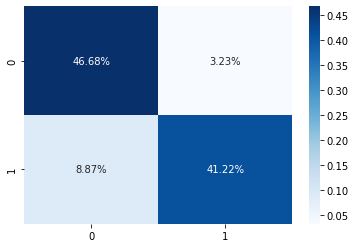

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sn.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
print (metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      2038
           1       0.93      0.82      0.87      2045

    accuracy                           0.88      4083
   macro avg       0.88      0.88      0.88      4083
weighted avg       0.88      0.88      0.88      4083



In [ ]:
from keras.models import load_model
model.save('/content/drive/MyDrive/MasterThesis/CNN/cnn.h5')

In [ ]:
with open('/content/drive/MyDrive/MasterThesis/Dataset/cnn_pred', 'wb') as f:
    pickle.dump(y_pred, f)    